# Supervised Prediction using Regression

- Created by Aman, J.

This notebook is an introduction to the machine learning concepts of clustering and preduction using regression. We will use the Building Data Genome Project data set to analyze electrical meter data from non-residential buildings.

This project has an open data set of 3,053 energy meters from 1,636 non-residential buildings with a range of two full years (2016 and 2017) at an hourly frequency (17,544 measurements per meter resulting in approximately 53.6 million measurements). 

## Using the Building Data Genome Project Data Set for Clustering and Regression Prediction

Let's use the lectrical meter data to create clusters of typical load profiles for analysis. First we can load our conventional packages

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib


Next let's load all the packages we will need for the clustering and regression analysis

In [2]:
import sklearn
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor

from scipy.cluster.vq import kmeans, vq, whiten
from scipy.spatial.distance import cdist
import numpy as np
from datetime import datetime


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.chdir("/content/gdrive/MyDrive/MIZZOU/OnlineCourse_edX_DataScienceForArchitectureConstruction/EDX Data Science for Construction, Architecture and Engineering/3 - Construction - Pandas Fundamentals/meter_data")

## Load electricity data and weather data


In [4]:
df_prediction_data = pd.read_csv("/content/gdrive/MyDrive/MIZZOU/_AT&T_Scripts/meter_data/UnivClass_Ciara.csv", parse_dates=True, index_col='timestamp')

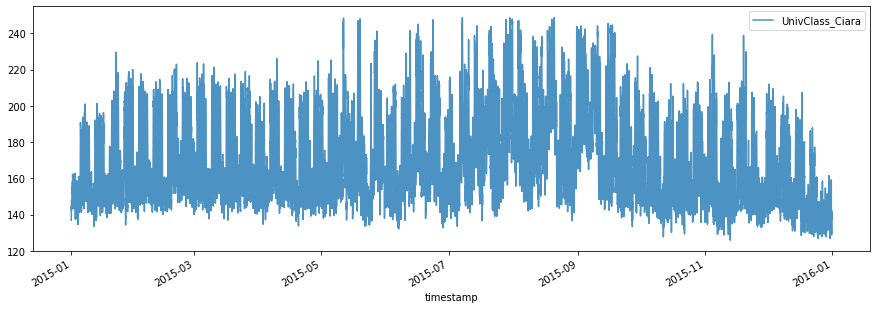

In [13]:
df_prediction_data.plot(alpha=0.8, figsize=(15, 5))

In [6]:
os.chdir("/content/gdrive/MyDrive/MIZZOU/_AT&T_Scripts/weather_data")
weather_data = pd.read_csv("weather2.csv", index_col='timestamp', parse_dates=True)

In [7]:
weather_hourly = weather_data.resample("H").mean()
weather_hourly_nooutlier = weather_hourly[weather_hourly > -40]
weather_hourly_nooutlier_nogaps = weather_hourly_nooutlier.fillna(method='ffill')

In [8]:
temperature = weather_hourly_nooutlier_nogaps["TemperatureC"]

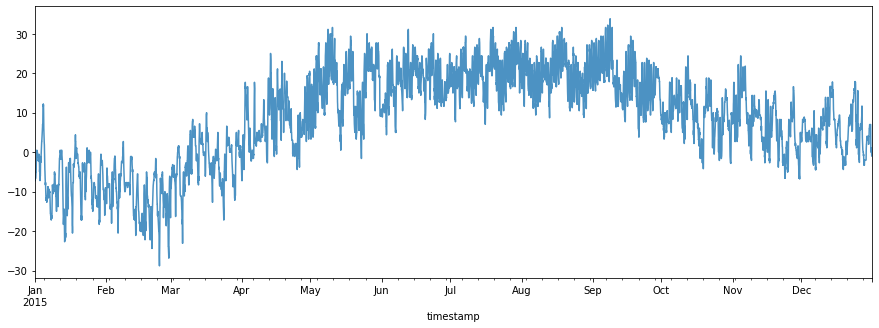

In [15]:
temperature.plot(alpha=0.8, figsize=(15, 5))

## Create Train and Test Datasets for Supervsed Learning

With **supervised learning**, the model is given a set of data that will be used to **train** the model to predict a specific objectice. In this case, we will use a few simple time series features as well as outdoor air temperature to predict how much energy a building uses.

For this demonstration, we will use three months of data from April, May, and June to prediction July.

In [16]:
training_months = [4,5,6]
test_months = [7]

We can divide the data set by using the `datetime index` of the data frame and a function known as `.isin` to extract the months for the model

In [17]:
trainingdata = df_prediction_data[df_prediction_data.index.month.isin(training_months)]
testdata = df_prediction_data[df_prediction_data.index.month.isin(test_months)]


In [18]:
testdata

,UnivClass_Ciara
timestamp,
2015-07-01 00:00:00,151.525002
2015-07-01 01:00:00,152.575005
2015-07-01 02:00:00,149.725006
2015-07-01 03:00:00,151.125000
2015-07-01 04:00:00,146.000000
...,...
2015-07-31 19:00:00,193.949997
2015-07-31 20:00:00,194.224998
2015-07-31 21:00:00,183.724998


In [19]:
trainingdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2184 entries, 2015-04-01 00:00:00 to 2015-06-30 23:00:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   UnivClass_Ciara  2184 non-null   float64
dtypes: float64(1)
memory usage: 34.1 KB


In [20]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2015-07-01 00:00:00 to 2015-07-31 23:00:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   UnivClass_Ciara  744 non-null    float64
dtypes: float64(1)
memory usage: 11.6 KB


We can extract the training input data features that will go into the model and the training **label** data which is what are are targeting to predict. 

## Encoding Categorical Variables 

We use the pandas `.get_dummies()` function to change the temporal variables of *time of day* and *day of week* into categories that the model can use more effectively. This process is known as [enconding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)

In [21]:
train_features = pd.concat([pd.get_dummies(trainingdata.index.hour), 
                                     pd.get_dummies(trainingdata.index.dayofweek), 
                                     pd.DataFrame(temperature[temperature.index.month.isin(training_months)].values)], axis=1).dropna()


In [22]:
train_features.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,0,1,2,3,4,5,6,0
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-5.5
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-6.1
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-7.2
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-6.6
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-7.2


## Train a K-Neighbor Regressor Model

This model was chosen after following the process in the cheat sheet until a model that worked and provided good results was found.

In [23]:
model = KNeighborsRegressor().fit(np.array(train_features), np.array(trainingdata.values));


In [24]:
test_features = np.array(pd.concat([pd.get_dummies(testdata.index.hour),
                                    pd.get_dummies(testdata.index.dayofweek),
                                    pd.DataFrame(temperature[temperature.index.month.isin(test_months)].values)], axis=1).dropna())



## Use the Model to predict for the *Test* period

Then the model is given the `test_features` from the period which we want to predict. We can then merge those results and see how the model did

In [25]:
predictions = model.predict(test_features)

In [26]:
predicted_vs_actual = pd.concat([testdata, pd.DataFrame(predictions, index=testdata.index)], axis=1)

In [27]:
predicted_vs_actual.columns = ["Actual", "Predicted"]

In [28]:
predicted_vs_actual.head()

,Actual,Predicted
timestamp,,
2015-07-01 00:00:00,151.525002,171.324998
2015-07-01 01:00:00,152.575005,185.139999
2015-07-01 02:00:00,149.725006,170.325003
2015-07-01 03:00:00,151.125000,187.010001
2015-07-01 04:00:00,146.000000,171.700002


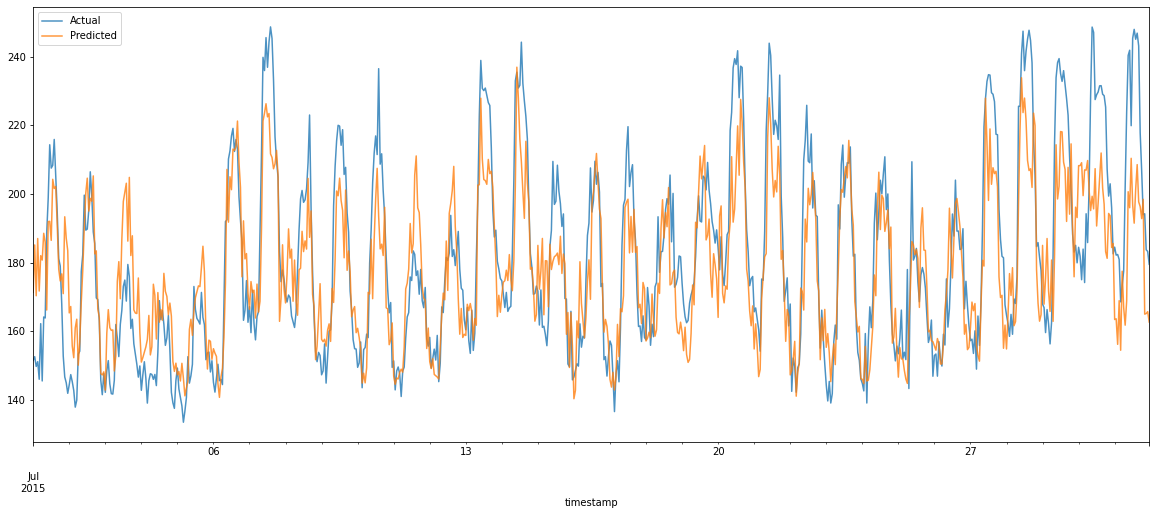

In [40]:
predicted_vs_actual.plot(alpha=0.8, figsize=(20, 8))

In [31]:
trainingdata.columns = ["Actual"]

In [32]:
predicted_vs_actual_plus_training = pd.concat([trainingdata, predicted_vs_actual], sort=True)

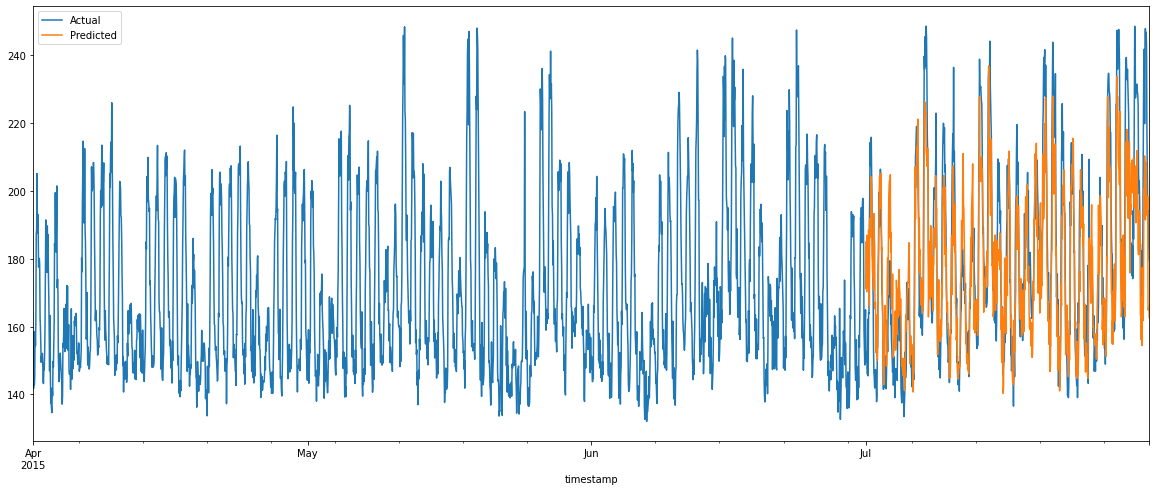

In [41]:
predicted_vs_actual_plus_training.plot(alpha=1, figsize=(20, 8))

## Regression evaluation metrics

In order to understand quanitatively how the model performed, we can use various evaluation metrics to understand how well the model compared to reality. 

In this situation, let's use the error metric [Mean Absolute Percentage Error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) 

In [37]:
# Calculate the absolute errors
errors = abs(predicted_vs_actual['Predicted'] - predicted_vs_actual['Actual'])
# Calculate mean absolute percentage error (MAPE) and add to list
MAPE = 100 * np.mean((errors / predicted_vs_actual['Actual']))

In [38]:
MAPE

6.8811507492394455